In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pickle

import emcee
from multiprocess import Pool
from getdist import plots, MCSamples

In [2]:
%matplotlib ipympl

In [2]:
base_dir = '/home/nahue-ofi/'
# base_dir = '/home/nahue/'

def give_cl_cmb(ell, r=0, Alens=1.):
        
    power_spectrum = hp.read_cl(base_dir+'CMM-Pipeline/src/data/Cls_Planck2018_lensed_scalar.fits')[:,:4000]
    if Alens != 1.:
        power_spectrum[2] *= Alens
    if r:
        power_spectrum += r * hp.read_cl(base_dir+'CMM-Pipeline/src/data/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits')[:,:4000]
    return np.interp(ell, np.arange(1, 4001, 1), power_spectrum[2])

# with open(base_dir+'CMM-Pipeline/src/autospectrum_cmb_d0_100_143_planck_parametric_d0_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
#     data1 = pickle.load(f)

# with open(base_dir+'CMM-Pipeline/src/autospectrum_cmb_d0_fullHFI_planck_parametric_d0_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
#     data1 = pickle.load(f)
    
with open(base_dir+'CMM-Pipeline/src/autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
    data = pickle.load(f)

# with open(base_dir+'CMM-Pipeline/src/autospectrum_cmbseed1_50reals_nofg.pkl', 'rb') as f:
#     datanofg = pickle.load(f)

_f = data['ell'] * (data['ell'] + 1) / (2 * np.pi)

print(data.keys())
print(np.shape(data['DlBB_i']))
nreals = np.shape(data['DlBB_i'])[0]

dict_keys(['ell', 'DlBB_i', 'DlBB_i_res', 'DlBB_mean', 'DlBB_mean_res'])
(100, 2, 2, 16)


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

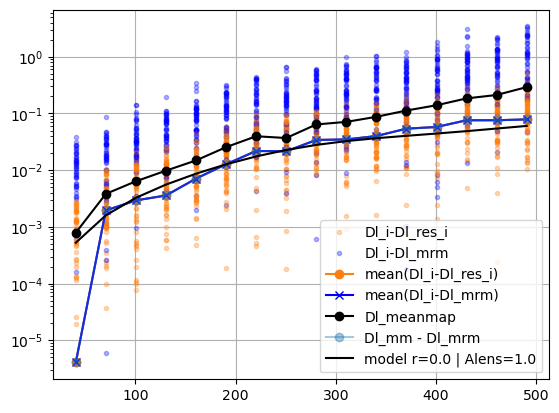

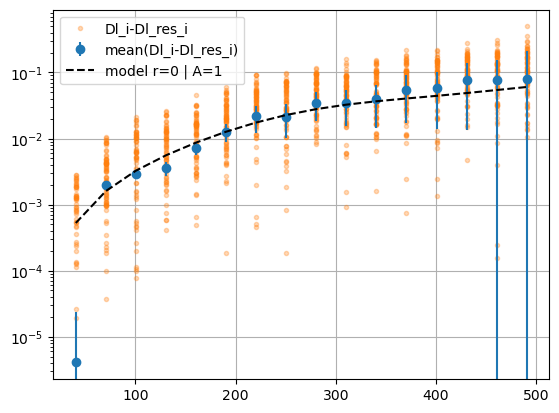

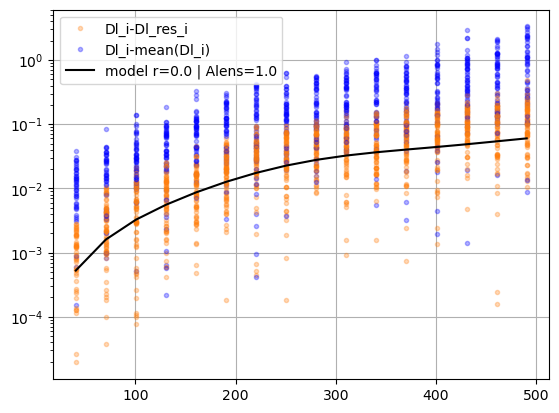

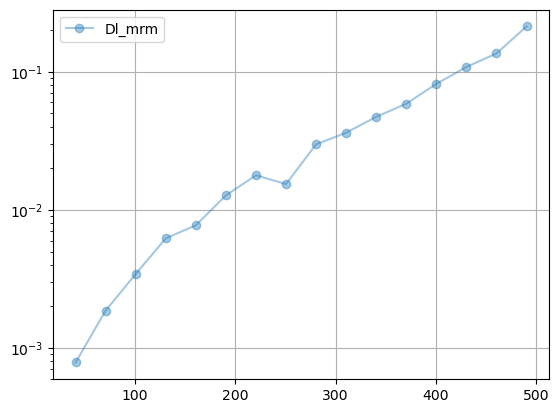

In [3]:
Alens = 1.
r = 0.

plt.figure()

for i in range(nreals):
    if i==0:
        # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3,label='Dl_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),'b.',alpha=0.3,label='Dl_i-Dl_mrm')
    # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),'b.',alpha=0.3)



# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:],axis=0), fmt='g-o', label='mean(Dl_i)')
plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = 'k-o', label = 'Dl_meanmap' )
plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:]-data['DlBB_mean_res'][0,0,:], fmt='-o', label='Dl_mm - Dl_mrm',alpha=0.4)
plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0),'C1-o',label='mean(Dl_i-Dl_res_i)')
plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),axis=0),'b-x',label='mean(Dl_i-Dl_mrm)')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)

plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout


plt.figure()

for i in range(nreals):
    if i==0:
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)

plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0),yerr = np.sqrt(len(data['DlBB_i'][:,0,0,0]))*np.std(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0)**2,fmt='o',label='mean(Dl_i-Dl_res_i)')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)



plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

plt.figure()

for i in range(nreals):
    if i==0:
        # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3,label='Dl_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i'][:,0,0,:],axis=0),'b.',alpha=0.3,label='Dl_i-mean(Dl_i)')
    # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i'][:,0,0,:],axis=0),'b.',alpha=0.3)



# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:],axis=0), fmt='g-o', label='mean(Dl_i)')
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = 'k-o', label = 'Dl_meanmap' )
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:]-data['DlBB_mean_res'][0,0,:], fmt='-o', label='Dl_mm - Dl_mrm',alpha=0.4)
# plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0),'C1-o',label='mean(Dl_i-Dl_res_i)')
# plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),axis=0),'b-x',label='mean(Dl_i-Dl_mrm)')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)

plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

plt.figure()

# for i in range(nreals):
#     if i==0:
#         # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3,label='Dl_i')
#         plt.plot(data['ell'],data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
#         # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i'][:,0,0,:],axis=0),'b.',alpha=0.3,label='Dl_i-mean(Dl_i)')
#     # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3)
#     plt.plot(data['ell'],data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)
#     # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i'][:,0,0,:],axis=0),'b.',alpha=0.3)



# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:],axis=0), fmt='g-o', label='mean(Dl_i)')
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = 'k-o', label = 'Dl_meanmap' )
plt.errorbar( data['ell'], data['DlBB_mean_res'][0,0,:], fmt='-o', label='Dl_mrm', alpha=0.4)
# plt.plot(data['ell'], np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),'C1-o',label='mean(Dl_i-Dl_res_i)')
# plt.plot(data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),axis=0),'b-x',label='mean(Dl_i-Dl_mrm)')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)

plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

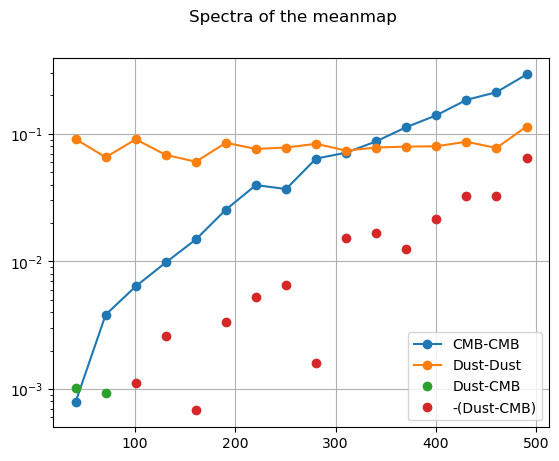

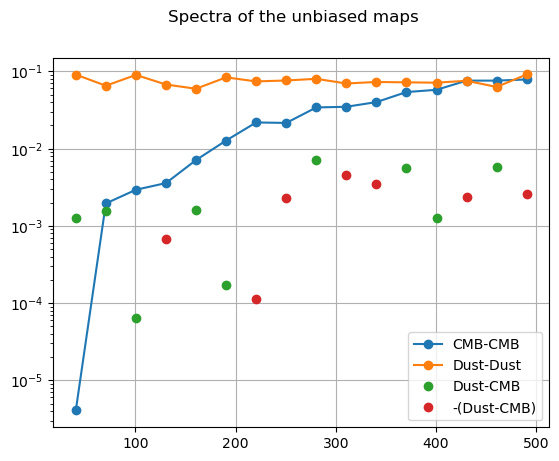

In [4]:
plt.figure()
plt.suptitle('Spectra of the meanmap')
plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = '-o', label = 'CMB-CMB' )
plt.errorbar( data['ell'], data['DlBB_mean'][1,1,:], fmt = '-o', label = 'Dust-Dust' )
plt.errorbar( data['ell'], data['DlBB_mean'][1,0,:], fmt = 'o', label = 'Dust-CMB' )
plt.errorbar( data['ell'], - data['DlBB_mean'][1,0,:], fmt = 'o', label = '-(Dust-CMB)' )
# plt.errorbar( data['ell'], data['DlBB_mean'][0,1,:], fmt = '-o', label = 'Dl_meanmap' )

plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

plt.figure()
plt.suptitle('Spectra of the unbiased maps')
plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 0, 0,:] - data['DlBB_i_res'][:, 0, 0,:],axis=0), fmt = '-o', label = 'CMB-CMB' )
plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 1, 1,:] - data['DlBB_i_res'][:, 1, 1,:],axis=0), fmt = '-o', label = 'Dust-Dust' )
plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = 'Dust-CMB' )
plt.errorbar( data['ell'], - np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = '-(Dust-CMB)' )
# plt.errorbar( data['ell'], data['DlBB_mean'][0,1,:], fmt = '-o', label = 'Dl_meanmap' )

plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

In [5]:
# plt.figure()
# plt.suptitle('data-data1')
# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 0, 0,:] - data['DlBB_i_res'][:, 0, 0,:],axis=0), fmt = '-o', label = 'data CC' )
# plt.errorbar( data['ell'], np.mean(data1['DlBB_i'][:, 0, 0,:] - data1['DlBB_i_res'][:, 0, 0,:],axis=0), fmt = '-o', label = 'data1 CC' )
# # plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = 'Dust-CMB' )
# # plt.errorbar( data['ell'], - np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = '-(Dust-CMB)' )
# # plt.errorbar( data['ell'], data['DlBB_mean'][0,1,:], fmt = '-o', label = 'Dl_meanmap' )

# plt.yscale('log')
# plt.grid()
# plt.legend()
# plt.tight_layout

# plt.figure()
# plt.suptitle('data-data1')
# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 1, 1,:] - data['DlBB_i_res'][:, 1, 1,:],axis=0), fmt = '-o', label = 'data DD' )
# plt.errorbar( data['ell'], np.mean(data1['DlBB_i'][:, 1, 1,:] - data1['DlBB_i_res'][:, 1, 1,:],axis=0), fmt = '-o', label = 'data1 DD' )
# # plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = 'Dust-CMB' )
# # plt.errorbar( data['ell'], - np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = '-(Dust-CMB)' )
# # plt.errorbar( data['ell'], data['DlBB_mean'][0,1,:], fmt = '-o', label = 'Dl_meanmap' )

# plt.yscale('log')
# plt.grid()
# plt.legend()
# plt.tight_layout

In [6]:
# plt.figure()
# plt.suptitle('data-data1')
# plt.errorbar( data['ell'], data['DlBB_mean'][0, 0,:], fmt = '-o', label = 'data CC' )
# plt.errorbar( data['ell'], data1['DlBB_mean'][0, 0,:], fmt = '-o', label = 'data1 CC' )
# # plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = 'Dust-CMB' )
# # plt.errorbar( data['ell'], - np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = '-(Dust-CMB)' )
# # plt.errorbar( data['ell'], data['DlBB_mean'][0,1,:], fmt = '-o', label = 'Dl_meanmap' )

# plt.yscale('log')
# plt.grid()
# plt.legend()
# plt.tight_layout

# plt.figure()
# plt.suptitle('data-data1')
# plt.errorbar( data['ell'], data['DlBB_mean'][1, 1,:], fmt = '-o', label = 'data CC' )
# plt.errorbar( data['ell'], data1['DlBB_mean'][1, 1,:], fmt = '-o', label = 'data1 CC' )
# # plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = 'Dust-CMB' )
# # plt.errorbar( data['ell'], - np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = '-(Dust-CMB)' )
# # plt.errorbar( data['ell'], data['DlBB_mean'][0,1,:], fmt = '-o', label = 'Dl_meanmap' )

# plt.yscale('log')
# plt.grid()
# plt.legend()
# plt.tight_layout

In [7]:
# cov_cc_dli = np.cov( data['DlBB_i'][:, 0, 0,:], rowvar = False )
# cov_cc = cov_cc_dli
# plt.figure()
# plt.suptitle('DlBB_i')
# vmax = np.max(np.abs(cov_cc[:, :]))
# plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov_cc_dlires = np.cov( data['DlBB_i_res'][:, 0, 0,:], rowvar = False )
# cov_cc = cov_cc_dlires
# plt.figure()
# plt.suptitle('DlBB_i_res')
# vmax = np.max(np.abs(cov_cc[:, :]))
# plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov_cc_dli_dlires = np.cov( data['DlBB_i'][:, 0, 0,:] - data['DlBB_i_res'][:, 0, 0,:], rowvar = False )
# cov_cc = cov_cc_dli_dlires
# plt.figure()
# plt.suptitle('DlBB_i - DlBB_i_res')
# vmax = np.max(np.abs(cov_cc[:, :]))
# plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov_cc_dli_meandli = np.cov( data['DlBB_i'][:, 0, 0,:] - np.mean(data['DlBB_i'][:, 0, 0,:], axis = 0 ), rowvar = False)
# cov_cc = cov_cc_dli_meandli
# plt.figure()
# plt.suptitle('DlBB_i - mean(DlBB_i)')
# vmax = np.max(np.abs(cov_cc[:, :]))
# plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov_cc_dli_meandlires = np.cov( data['DlBB_i'][:, 0, 0,:] - np.mean(data['DlBB_i_res'][:, 0, 0,:], axis = 0 ), rowvar = False)
# cov_cc = cov_cc_dli_meandlires
# plt.figure()
# plt.suptitle('DlBB_i - mean(DlBB_i_res)')
# vmax = np.max(np.abs(cov_cc[:, :]))
# plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov_cc_diag_1 = np.zeros((16,16))
# np.fill_diagonal(cov_cc_diag_1, np.std(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:], axis=0)**2)
# cov_cc = cov_cc_diag_1
# plt.figure()
# plt.suptitle('diag std(Dl_i-Dl_i_res)**2')
# vmax = np.max(np.abs(cov_cc[:, :]))
# plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# cov_cc_diag_2 = np.zeros((16,16))
# np.fill_diagonal(cov_cc_diag_2, data['DlBB_mean_res'][0,0,:])
# cov_cc = cov_cc_diag_2
# plt.figure()
# plt.suptitle('diag DlBB_mean_res')
# vmax = np.max(np.abs(cov_cc[:, :]))
# plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

/tmp/ipykernel_7865/1943201438.py:20: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(cov_complete[:, :]), cmap='bwr')
/tmp/ipykernel_7865/1943201438.py:33: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(cov_inv[:, :]), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')


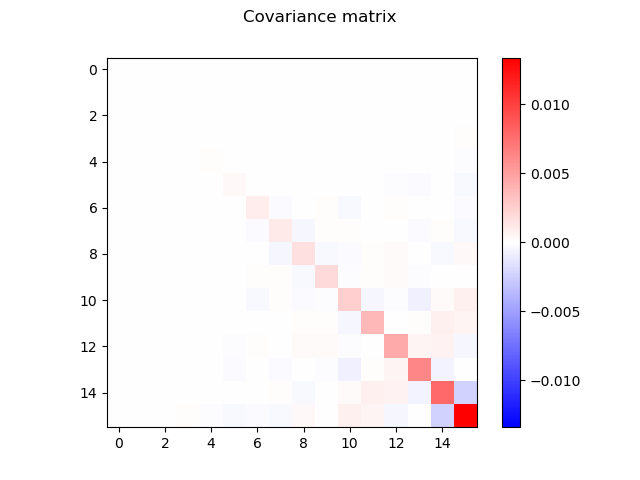

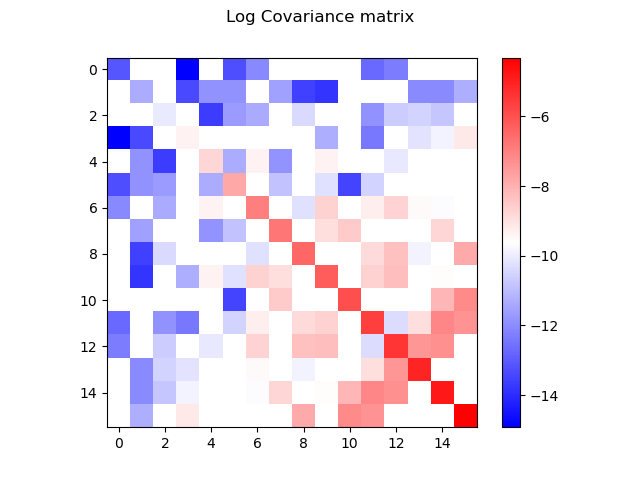

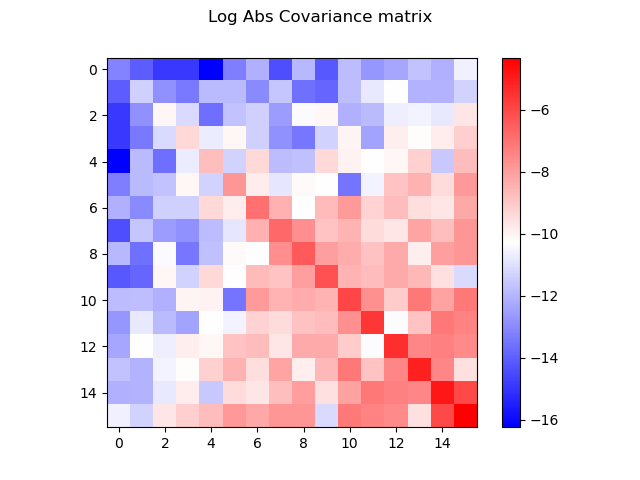

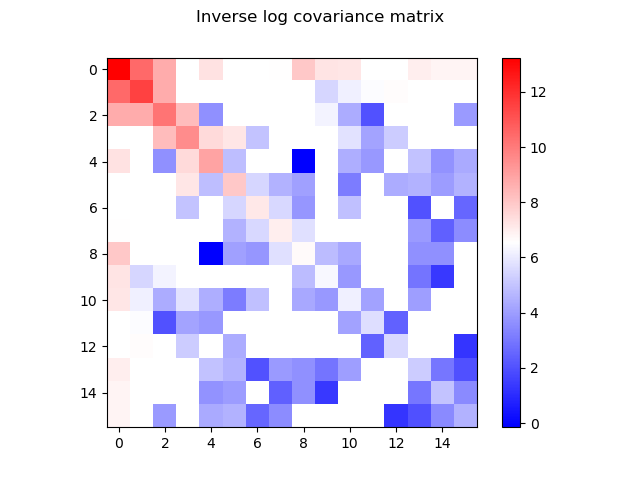

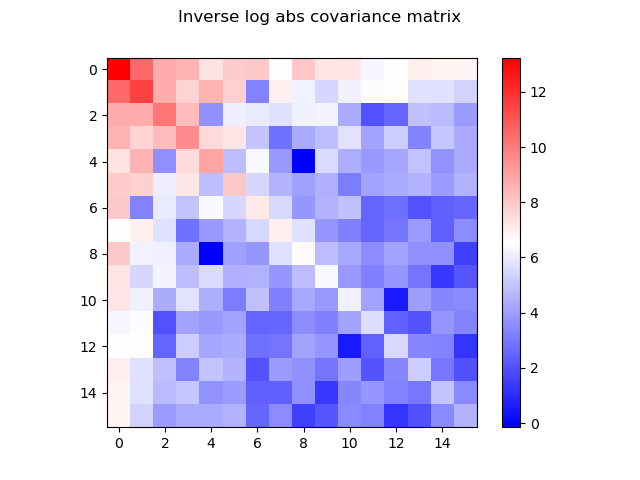

In [12]:
data_cc = data['DlBB_i'][:, 0, 0,:] - data['DlBB_i_res'][:, 0, 0,:]#data['DlBB_i_res'][:, 0, 0,:]#
data_dd = data['DlBB_i'][:, 1, 1,:] - data['DlBB_i_res'][:, 1, 1,:]#data['DlBB_i_res'][:, 1, 1,:]#
data_dc = data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:]#data['DlBB_i_res'][:, 1, 0,:]#

data_for_cov = np.append(data_cc, data_dd,axis=1)
data_for_cov = np.append(data_for_cov, data_dc,axis=1)
# print(data_for_cov)
# cov_complete = np.cov(data_for_cov, rowvar=False)
cov_complete = np.cov(data_cc, rowvar=False)

plt.figure()

plt.suptitle('Covariance matrix')
vmax = np.max(np.abs(cov_complete[:, :]))
plt.imshow(cov_complete[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

plt.figure()
plt.suptitle('Log Covariance matrix')
plt.imshow(np.log(cov_complete[:, :]), cmap='bwr')
plt.colorbar()

plt.figure()
plt.suptitle('Log Abs Covariance matrix')
plt.imshow(np.log(np.abs(cov_complete[:, :])), cmap='bwr')
plt.colorbar()

cov_inv = np.linalg.inv(cov_complete)

plt.figure()

plt.suptitle('Inverse log covariance matrix')
plt.imshow(np.log(cov_inv[:, :]), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

plt.figure()

plt.suptitle('Inverse log abs covariance matrix')
plt.imshow(np.log(np.abs(cov_inv[:, :])), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

/tmp/ipykernel_7865/373364067.py:30: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(cov_cc_dd_dc_diag[:, :]), cmap='bwr')
/tmp/ipykernel_7865/373364067.py:35: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(cov_cc_dd_dc_diag[:, :])), cmap='bwr')
/tmp/ipykernel_7865/373364067.py:44: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(cov_inv[:, :]), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')
/tmp/ipykernel_7865/373364067.py:51: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(cov_inv[:, :])), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')


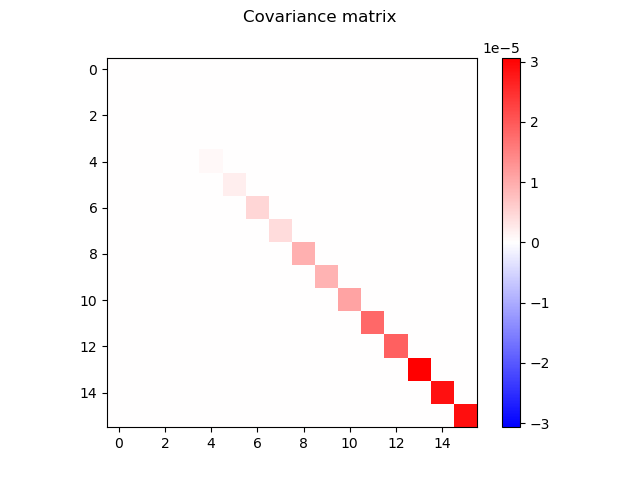

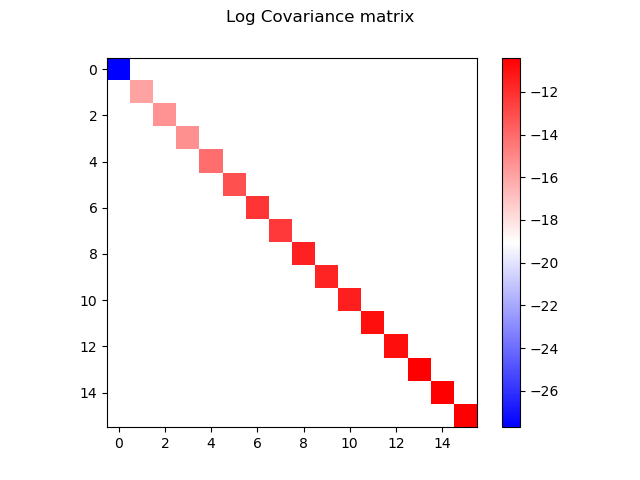

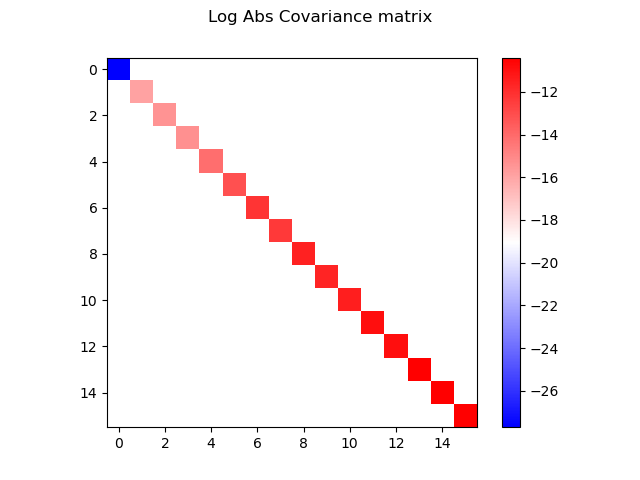

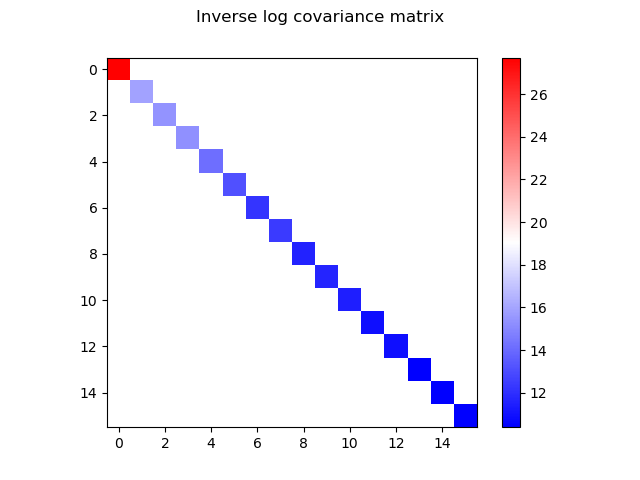

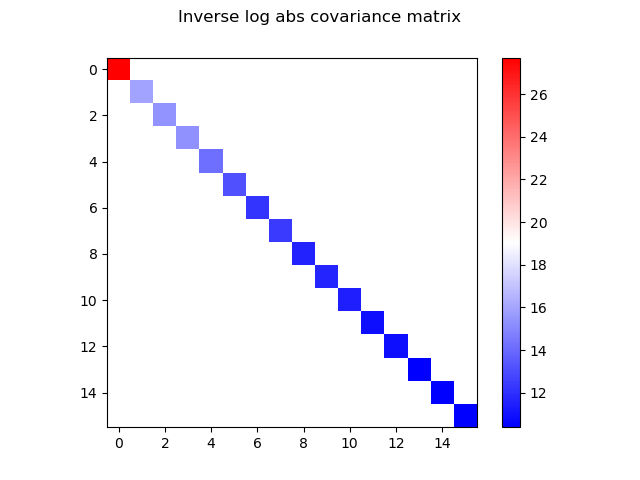

In [26]:
cov_cc_diag_1 = np.zeros((16,16))
np.fill_diagonal(cov_cc_diag_1, np.std(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:], axis=0)**2)

cov_cc_diag_1 = np.zeros((16,16))
np.fill_diagonal(cov_cc_diag_1, 2/(2*data['ell']+1)*1/(0.0145)*(1/30)*(np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0))**2)#

cov_dd_diag_1 = np.zeros((16,16))
np.fill_diagonal(cov_dd_diag_1, np.std(data['DlBB_i'][:,1,1,:]-data['DlBB_i_res'][:,1,1,:], axis=0)**2)

cov_dc_diag_1 = np.zeros((16,16))
np.fill_diagonal(cov_dc_diag_1, np.std(data['DlBB_i'][:,1,0,:]-data['DlBB_i_res'][:,1,0,:], axis=0)**2)

# cov_cc_dd_dc_diag = np.zeros((48,48))
cov_cc_dd_dc_diag = np.zeros((16,16))

cov_cc_dd_dc_diag[:16,:16] = cov_cc_diag_1
# cov_cc_dd_dc_diag[16:32,16:32] = cov_dd_diag_1
# cov_cc_dd_dc_diag[32:,32:] = cov_dc_diag_1

plt.figure()

plt.suptitle('Covariance matrix')
vmax = np.max(np.abs(cov_cc_dd_dc_diag[:, :]))
plt.imshow(cov_cc_dd_dc_diag[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

plt.figure()

plt.suptitle('Log Covariance matrix')
plt.imshow(np.log(cov_cc_dd_dc_diag[:, :]), cmap='bwr')
plt.colorbar()

plt.figure()
plt.suptitle('Log Abs Covariance matrix')
plt.imshow(np.log(np.abs(cov_cc_dd_dc_diag[:, :])), cmap='bwr')
plt.colorbar()

cov_inv = np.linalg.inv(cov_cc_dd_dc_diag)

plt.figure()

plt.suptitle('Inverse log covariance matrix')
vmax = np.max(np.abs(cov_inv[:, :]))
plt.imshow(np.log(cov_inv[:, :]), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

plt.figure()

plt.suptitle('Inverse log abs covariance matrix')
vmax = np.max(np.abs(cov_inv[:, :]))
plt.imshow(np.log(np.abs(cov_inv[:, :])), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

In [7]:
cov = cov_complete#cov_cc_dd_dc_diag#

cov_inv = np.linalg.inv(cov)

observation_meanmap = np.array([data['DlBB_mean'][0,0,:], data['DlBB_mean'][1,1,:], data['DlBB_mean'][1,0,:]])
observation_unbiased = np.array([np.mean(data['DlBB_i'][:,0,0,:] - data['DlBB_i_res'][:,0,0,:], axis=0),
                                 np.mean(data['DlBB_i'][:,1,1,:] - data['DlBB_i_res'][:,1,1,:], axis=0),
                                 np.mean(data['DlBB_i'][:,1,0,:] - data['DlBB_i_res'][:,1,0,:], axis=0)])

# observation = observation_meanmap

observation = observation_unbiased


In [43]:
like_components = 'cmb_dust'

cross_spec = True #use the information of the cross spectrum <Dust CMB>

dc_model = 'scaling' #   'const' #'zero' #

corr_between_spectra = False #use the blocks of the cov matrix that correlates the different spectra. E.g. the block <Dust^2><CMB^2>
                             #or <Dust CMB> <CMB^2>

# cross_spec_cmb_dust = True

# cross_cov_cmb_dust = True

In [44]:
def foregrounds(ell, A, alpha):
    return A * (ell/80)**alpha
    
def log_prior(x):
    
    if like_components == 'cmb':

        r, Alens = x

        if r > 1 or r < -1:
            return -np.inf
    
        if Alens < 0.1 or Alens > 4:
            return -np.inf

    elif like_components == 'cmb_dust':

        if not cross_spec:
            
            r, Alens, A, alpha = x
            
            if r > 1 or r < -1:
                return -np.inf
        
            if Alens < 0.1 or Alens > 4:
                return -np.inf
        
            if alpha > 1 or alpha < -1:
                return -np.inf
        
            if A > 0.1 or A < -0.1:
                return -np.inf
        
        else:
            
            if dc_model == 'zero':
                
                r, Alens, A, alpha = x
                
                if r > 1 or r < -1:
                    return -np.inf
            
                if Alens < 0.1 or Alens > 4:
                    return -np.inf
            
                if alpha > 1 or alpha < -1:
                    return -np.inf
            
                if A > 0.1 or A < -0.1:
                    return -np.inf
    
            elif dc_model == 'const':
                
                r, Alens, A, alpha, Adc = x
                
                if r > 1 or r < -1:
                    return -np.inf
            
                if Alens < 0.1 or Alens > 4:
                    return -np.inf
            
                if alpha > 1 or alpha < -1:
                    return -np.inf
            
                if A > 0.1 or A < -0.1:
                    return -np.inf
                    
                if Adc > 0.1 or Adc < -0.1:
                    return -np.inf
            
            elif dc_model == 'scaling':
                
                r, Alens, A, alpha, Adc, alphadc = x
                
                if r > 1 or r < -1:
                    return -np.inf
            
                if Alens < 0.1 or Alens > 4:
                    return -np.inf
            
                if alpha > 1 or alpha < -1:
                    return -np.inf
            
                if A > 0.1 or A < -0.1:
                    return -np.inf
    
                if alphadc > 0.1 or alphadc < -0.1:
                    return -np.inf
            
                if Adc > 0.01 or Adc < -0.01:
                    return -np.inf
    
    else:
        
        raise Exception('The components in the likelihood can be: cmb or cmb_dust')
        
    return 0

def like(x):

    nbins_ell = len(data['ell'])

    if like_components == 'cmb':

        r, Alens = x
        
        ymodel = np.array([_f * give_cl_cmb(data['ell'], r, Alens)])
        yobs = observation[0]
        res = ymodel - yobs

        lp = log_prior(x)
        
        L_cc2 = - 0.5 * ((res[0].T @ cov_inv[:nbins_ell,:nbins_ell] @ res[0]))
        
        L = lp + L_cc2
        
    elif like_components == 'cmb_dust':
        
        if not cross_spec:

            r, Alens, A, alpha = x
            
            ymodel = np.array([_f * give_cl_cmb(data['ell'], r, Alens), foregrounds(data['ell'], A, alpha)])
            yobs = observation[:2]
            res = ymodel - yobs
    
            lp = log_prior(x)
            
            L_cc2 = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,:nbins_ell] @ res[0])
            L_dd2 = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,nbins_ell:2*nbins_ell] @ res[1])

            if not corr_between_spectra:

                L = lp + L_cc2 + L_dd2

            else:
                
                L_ddcc = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,:nbins_ell] @ res[0])
                L_ccdd = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,nbins_ell:2*nbins_ell] @ res[1])
            
                L = lp + L_cc2 + L_dd2 + L_ddcc + L_ccdd
            
        else:

            yobs = observation
            
            lp = log_prior(x)
            
            if dc_model == 'zero':

                r, Alens, A, alpha = x
             
                ymodel = np.array([_f * give_cl_cmb(data['ell'], r, Alens), foregrounds(data['ell'], A, alpha), np.zeros(len(data['ell']))])
                
                res = ymodel - yobs
                
                L_cc2 = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,:nbins_ell] @ res[0])
                L_dd2 = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,nbins_ell:2*nbins_ell] @ res[1])
                L_dc2 = - 0.5 * (res[2].T @ cov_inv[2*nbins_ell:,2*nbins_ell:] @ res[2])

                if not corr_between_spectra:
    
                    L = lp + L_cc2 + L_dd2 + L_dc2
                    
                else:
                    
                    L_ddcc = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,:nbins_ell] @ res[0])
                    L_ccdd = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,nbins_ell:2*nbins_ell] @ res[1])
                    
                    L_ccdc = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,2*nbins_ell:] @ res[2])
                    L_dccc = - 0.5 * (res[2].T @ cov_inv[2*nbins_ell:,:nbins_ell] @ res[0])
                    
                    L_dcdd = - 0.5 * (res[2].T @ cov_inv[2*nbins_ell:,nbins_ell:2*nbins_ell] @ res[1])
                    L_dddc = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,2*nbins_ell:] @ res[2])
                
                    L = lp + L_cc2 + L_dd2 + L_dc2 + L_ddcc + L_ccdd + L_ccdc + L_ccdc + L_dccc + L_dcdd + L_dddc

            elif dc_model == 'const':
                
                r, Alens, A, alpha, Adc = x
             
                ymodel = np.array([_f * give_cl_cmb(data['ell'], r, Alens), foregrounds(data['ell'], A, alpha),
                                   Adc * np.ones(len(data['ell']))])
                
                res = ymodel - yobs
                
                L_cc2 = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,:nbins_ell] @ res[0])
                L_dd2 = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,nbins_ell:2*nbins_ell] @ res[1])
                L_dc2 = - 0.5 * (res[2].T @ cov_inv[2*nbins_ell:,2*nbins_ell:] @ res[2])

                if not corr_between_spectra:
    
                    L = lp + L_cc2 + L_dd2 + L_dc2
                    
                else:
                    
                    L_ddcc = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,:nbins_ell] @ res[0])
                    L_ccdd = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,nbins_ell:2*nbins_ell] @ res[1])
                    
                    L_ccdc = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,2*nbins_ell:] @ res[2])
                    L_dccc = - 0.5 * (res[2].T @ cov_inv[2*nbins_ell:,:nbins_ell] @ res[0])
                    
                    L_dcdd = - 0.5 * (res[2].T @ cov_inv[2*nbins_ell:,nbins_ell:2*nbins_ell] @ res[1])
                    L_dddc = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,2*nbins_ell:] @ res[2])
                
                    L = lp + L_cc2 + L_dd2 + L_dc2 + L_ddcc + L_ccdd + L_ccdc + L_ccdc + L_dccc + L_dcdd + L_dddc

            elif dc_model == 'scaling':
                
                r, Alens, A, alpha, Adc, alphadc = x
             
                ymodel = np.array([_f * give_cl_cmb(data['ell'], r, Alens), foregrounds(data['ell'], A, alpha),
                                   foregrounds(data['ell'], Adc, alphadc)])
                
                res = ymodel - yobs
                
                L_cc2 = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,:nbins_ell] @ res[0])
                L_dd2 = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,nbins_ell:2*nbins_ell] @ res[1])
                L_dc2 = - 0.5 * (res[2].T @ cov_inv[2*nbins_ell:,2*nbins_ell:] @ res[2])

                if not corr_between_spectra:
    
                    L = lp + L_cc2 + L_dd2 + L_dc2
                    
                else:
                    
                    L_ddcc = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,:nbins_ell] @ res[0])
                    L_ccdd = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,nbins_ell:2*nbins_ell] @ res[1])
                    
                    L_ccdc = - 0.5 * (res[0].T @ cov_inv[:nbins_ell,2*nbins_ell:] @ res[2])
                    L_dccc = - 0.5 * (res[2].T @ cov_inv[2*nbins_ell:,:nbins_ell] @ res[0])
                    
                    L_dcdd = - 0.5 * (res[2].T @ cov_inv[2*nbins_ell:,nbins_ell:2*nbins_ell] @ res[1])
                    L_dddc = - 0.5 * (res[1].T @ cov_inv[nbins_ell:2*nbins_ell,2*nbins_ell:] @ res[2])
                
                    L = lp + L_cc2 + L_dd2 + L_dc2 + L_ddcc + L_ccdd + L_ccdc + L_ccdc + L_dccc + L_dcdd + L_dddc
    
    return L

In [45]:
nwalkers = 30

if like_components == 'cmb':
    
    nparams = 2
    
    x0 = np.zeros((nwalkers, nparams))
    
    x0[:, 0] = np.random.normal(0.036, 0.01, (nwalkers))
    x0[:, 1] = np.random.normal(1, 0.01, (nwalkers))   
    
elif like_components == 'cmb_dust':

    if dc_model == 'zero':
        
        nparams = 4
        
        x0 = np.zeros((nwalkers, nparams))
        
        x0[:, 0] = np.random.normal(0.036, 0.01, (nwalkers))
        x0[:, 1] = np.random.normal(1, 0.01, (nwalkers))
        x0[:, 2] = np.random.normal(0.08, 0.005, (nwalkers))
        x0[:, 3] = np.random.normal(-0.01, 0.005, (nwalkers))

    elif dc_model == 'const':
        
        nparams = 5
        
        x0 = np.zeros((nwalkers, nparams))
        
        x0[:, 0] = np.random.normal(0.036, 0.01, (nwalkers))
        x0[:, 1] = np.random.normal(1, 0.01, (nwalkers))
        x0[:, 2] = np.random.normal(0.08, 0.005, (nwalkers))
        x0[:, 3] = np.random.normal(-0.01, 0.005, (nwalkers))
        x0[:, 4] = np.random.normal(0.00, 0.005, (nwalkers))
        
    elif dc_model == 'scaling':
        
        nparams = 6
        
        x0 = np.zeros((nwalkers, nparams))
        
        x0[:, 0] = np.random.normal(0.036, 0.01, (nwalkers))
        x0[:, 1] = np.random.normal(1, 0.01, (nwalkers))
        x0[:, 2] = np.random.normal(0.08, 0.005, (nwalkers))
        x0[:, 3] = np.random.normal(-0.01, 0.005, (nwalkers))
        x0[:, 4] = np.random.normal(0.0, 0.005, (nwalkers))
        x0[:, 5] = np.random.normal(0.0, 0.05, (nwalkers))


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, nparams, like, pool=pool)
    sampler.run_mcmc(x0, 3000)#, progress=True)

chains = sampler.get_chain()

/home/nahue/anaconda3/envs/qubic/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


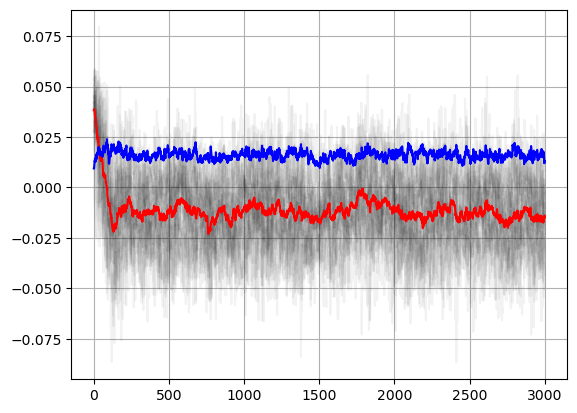

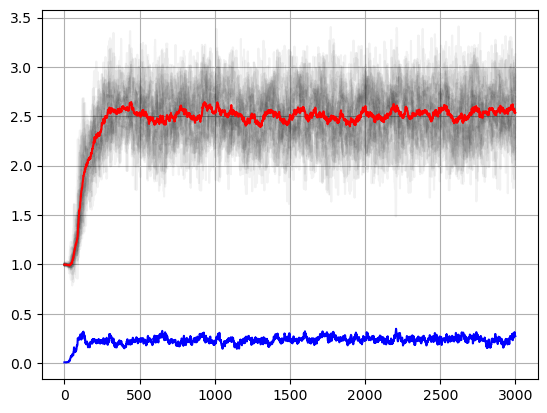

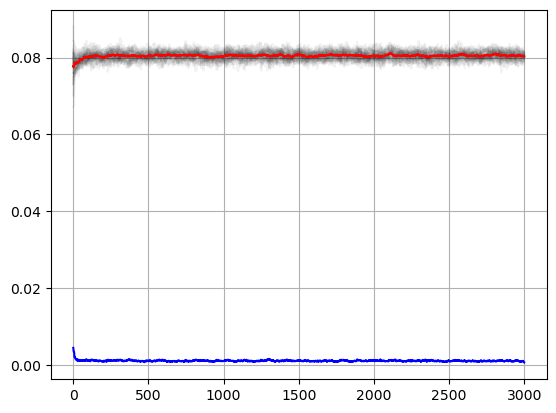

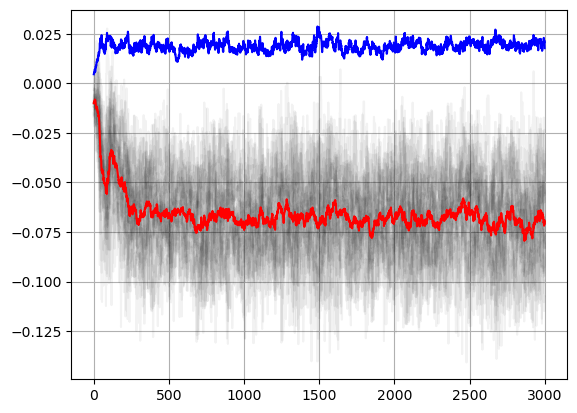

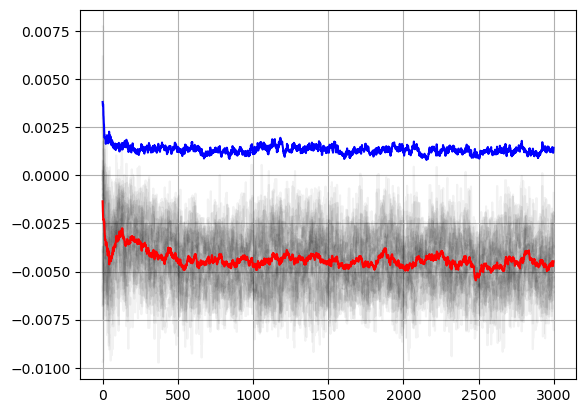

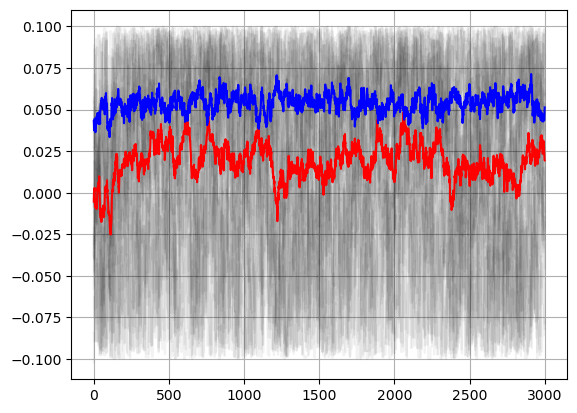

In [46]:
for j in range(nparams):
    
    plt.figure()
    
    for i in range(nwalkers):
        plt.plot(chains[:, i, j], '-k', alpha=0.05)
    plt.plot(np.mean(chains, axis=1)[:, j], '-r')
    plt.plot(np.std(chains, axis=1)[:, j], '-b')
    # plt.axhline(0, ls='--', color='black')
    # plt.axhline(0.015, ls='--', color='green')
    # plt.xlim(0, chains.shape[0])
    # plt.ylim(-0.05, 0.1)
    plt.grid()
    plt.tight_layout

Removed no burn in


<Figure size 1200x800 with 0 Axes>

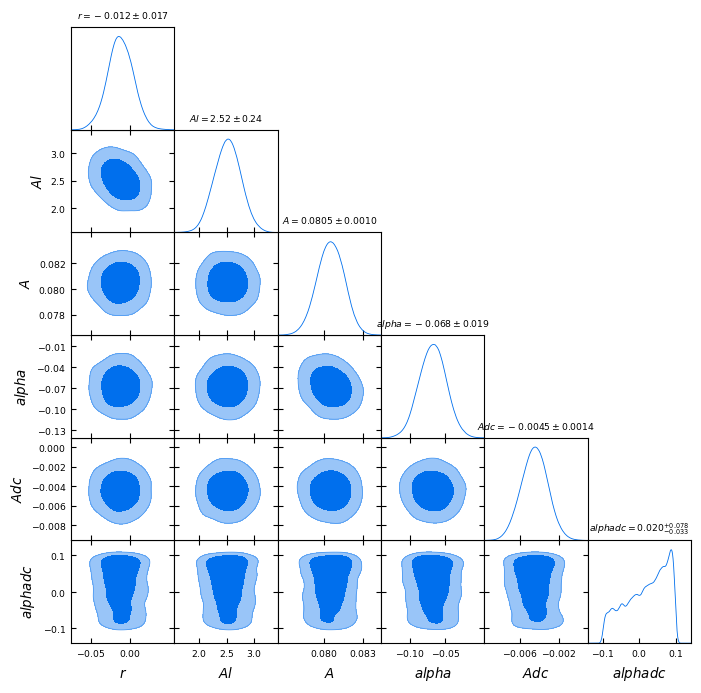

In [47]:
chainflat = sampler.get_chain(discard=300, thin=15, flat=True)

names_all = ['r','Al','A','alpha','Adc','alphadc']

labels = []
names = []
for i in range(nparams):
    names += [f'{names_all[i]}']
    labels += [f'{names_all[i]}']
            
s = MCSamples(samples=chainflat, names=names, labels=labels, label=r'')#, ranges={'r':(0, None)})

plt.figure(figsize=(12, 8))

# Triangle plot
g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot([s], filled=True, title_limit=1)
# plt.savefig('r_Alens_A_alpha_cov_cd_obs_unbiased')
plt.show()

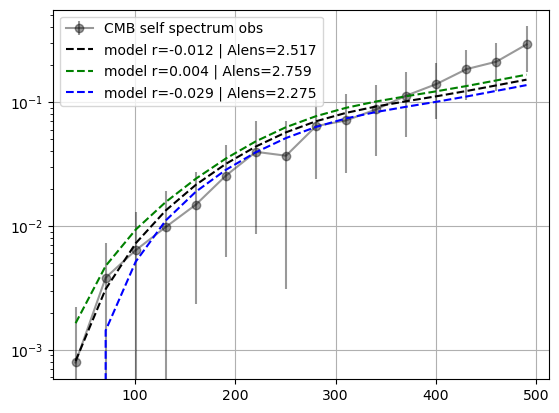

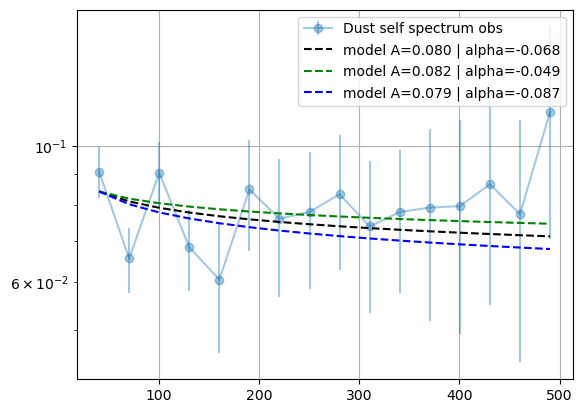

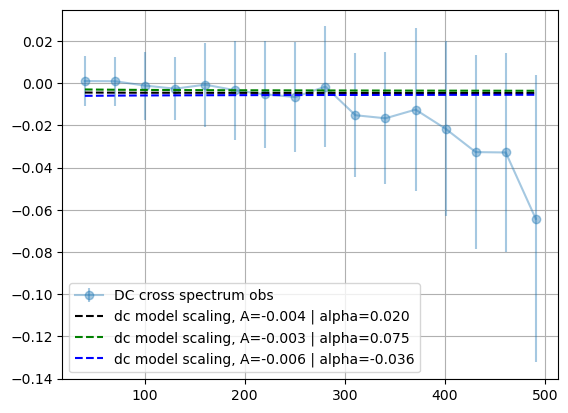

In [48]:

if like_components == 'cmb':
    
    r = np.mean(chainflat[:,0])
    Alens = np.mean(chainflat[:,1])
    sr = np.std(chainflat[:,0])
    sAlens = np.std(chainflat[:,1])
    
elif like_components == 'cmb_dust':

    r = np.mean(chainflat[:,0])
    Alens = np.mean(chainflat[:,1])
    A = np.mean(chainflat[:,2])
    alpha = np.mean(chainflat[:,3])
    sr = np.std(chainflat[:,0])
    sAlens = np.std(chainflat[:,1])
    sA = np.std(chainflat[:,2])
    salpha = np.std(chainflat[:,3])

    if cross_spec:
        
        if dc_model == 'zero':
            
            Adc = 0.
            alphadc = 0.
            sAdc = 0.
            salphadc = 0.
            
        elif dc_model == 'const':
    
            Adc = np.mean(chainflat[:,4])
            alphadc = 0.
            sAdc = np.std(chainflat[:,4])
            salphadc = 0.
    
        elif dc_model == 'scaling':
            
            Adc = np.mean(chainflat[:,4])
            alphadc = np.mean(chainflat[:,5])
            sAdc = np.std(chainflat[:,4])
            salphadc = np.std(chainflat[:,5])

nbins_ell = len(data['ell'])
            
plt.figure()
plt.errorbar( data['ell'], observation[0],yerr=np.sqrt(np.diagonal(cov[:nbins_ell,:nbins_ell])), fmt = 'k-o', label = 'CMB self spectrum obs',alpha=0.4 )
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='--k', label=f'model r={r:.3f} | Alens={Alens:.3f}',)
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r+sr, Alens+sAlens), fmt='--g', label=f'model r={r+sr:.3f} | Alens={Alens+sAlens:.3f}',)
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r-sr, Alens-sAlens), fmt='--b', label=f'model r={r-sr:.3f} | Alens={Alens-sAlens:.3f}',)

plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

if like_components == 'cmb_dust':

    plt.figure()
    plt.errorbar( data['ell'], observation[1],yerr=np.sqrt(np.diagonal(cov[nbins_ell:2*nbins_ell,nbins_ell:2*nbins_ell])), fmt='-o', label='Dust self spectrum obs',alpha=0.4)
    plt.errorbar( data['ell'], foregrounds(data['ell'], A, alpha), fmt='--k', label=f'model A={A:.3f} | alpha={alpha:.3f}')
    plt.errorbar( data['ell'], foregrounds(data['ell'], A+sA, alpha+salpha), fmt='--g', label=f'model A={A+sA:.3f} | alpha={alpha+salpha:.3f}')
    plt.errorbar( data['ell'], foregrounds(data['ell'], A-sA, alpha-salpha), fmt='--b', label=f'model A={A-sA:.3f} | alpha={alpha-salpha:.3f}')
    
    plt.yscale('log')
    plt.grid()
    plt.legend()
    plt.tight_layout

    if cross_spec:
    
        plt.figure()
        plt.errorbar( data['ell'], observation[2],yerr=np.sqrt(np.diagonal(cov[2*nbins_ell:,2*nbins_ell:])), fmt='-o', label='DC cross spectrum obs',alpha=0.4)
        plt.errorbar( data['ell'], foregrounds(data['ell'],Adc,alphadc), fmt='--k', label=f'dc model {dc_model}, A={Adc:.3f} | alpha={alphadc:.3f}')
        plt.errorbar( data['ell'], foregrounds(data['ell'], Adc+sAdc, alphadc+salphadc), fmt='--g', label=f'dc model {dc_model}, A={Adc+sAdc:.3f} | alpha={alphadc+salphadc:.3f}')
        plt.errorbar( data['ell'], foregrounds(data['ell'], Adc-sAdc, alphadc-salphadc), fmt='--b', label=f'dc model {dc_model}, A={Adc-sAdc:.3f} | alpha={alphadc-salphadc:.3f}')
        
        
        # plt.yscale('log')
        plt.grid()
        plt.legend()
        plt.tight_layout